### 设置环境类 -- AlwaysForwardEnv
我们希望它永远向前，但我们有向前和退后两个操作

In [287]:
"""
0 是往前，1是退后
"""
class AlwaysForwardEnv:
    def __init__(self, length):
        self.length = length
        self.position = 0
        
        self.action_dim = 2
        self.state_dim = 1
    
    def reset(self):
        self.position = 0
        return self.position
    
    def step(self, action):
        if action == 0:
            self.position += 1
            reward = 1
        elif action == 1:
            self.position -= 1
            reward = 0
        else:
            raise ValueError("Invalid action")
            
        done = self.position >= self.length
        return self.position, reward, done, {}

In [281]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [282]:
_env = AlwaysForwardEnv(10)
init_pos = _env.position
pos_records = []
action_records = []
reward_records = []

# 使用一个loop进行随机模拟
done = None
for i in range(100):
    if done:
        print(f'Completed in {i+1} steps.')
        break
    # choose random action
    current_action = np.random.randint(0, _env.action_dim)
    
    current_pos, reward, done, _ = _env.step(current_action)
    
    pos_records.append(current_pos)
    action_records.append(current_action)
    reward_records.append(reward)

In [359]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [360]:
softmax([np.random.randn(10)])

array([[0.01303363, 0.1433465 , 0.26541862, 0.1208436 , 0.02282404,
        0.13699106, 0.03514259, 0.13670107, 0.06167769, 0.06402119]])

In [336]:
_env = AlwaysForwardEnv(10)
init_pos = _env.position
pos_records = []
action_records = []
reward_records = []
probs_records = []

# 初始化action概率分布
action_probs = np.ones(_env.action_dim) / _env.action_dim
alpha = 1

# 对以上代码的随机模拟部分进行改变，使其能够实现最基本的”学习“
done = None

for i in range(100):
    if done:
        print(f'Completed in {i+1} steps.')
        break
    # choose random action(with biased probs)
    current_action = np.random.choice(_env.action_dim, p=action_probs)
    
    current_pos, reward, done, _ = _env.step(current_action)

    # 根据reward值调整概率分布
    action_probs[current_action] = action_probs[current_action] + alpha * (reward - action_probs[current_action])
    action_probs = softmax(action_probs)
    
    pos_records.append(current_pos)
    action_records.append(current_action)
    reward_records.append(reward)
    probs_records.append(action_probs)

Completed in 13 steps.


In [338]:
probs_records

[array([1.        , 0.37754067]),
 array([1.        , 0.34922232]),
 array([1.        , 0.34281431]),
 array([1.        , 0.34137209]),
 array([1.       , 0.3410479]),
 array([1.        , 0.34097505]),
 array([1.        , 0.34095868]),
 array([0.659045, 0.      ]),
 array([1.        , 0.34095417]),
 array([1.        , 0.34095399]),
 array([1.        , 0.34095394]),
 array([0.65904607, 0.34095393])]

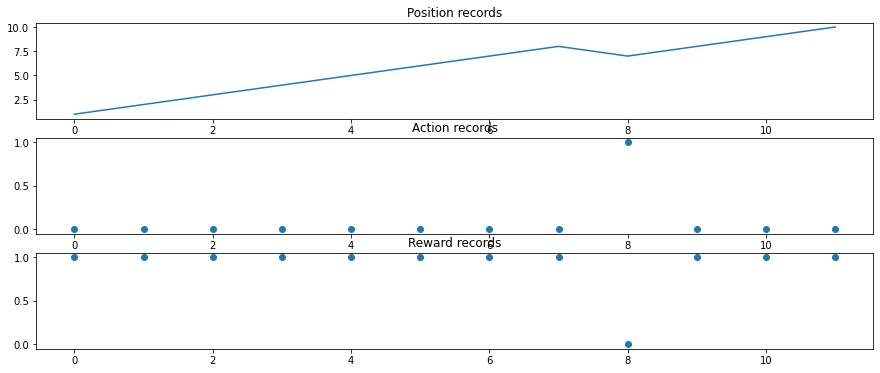

In [337]:
# 可视化结果
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
plt.plot(pos_records)
plt.title('Position records')

plt.subplot(3, 1, 2)
plt.scatter(range(len(action_records)), action_records)
plt.title('Action records')

plt.subplot(3, 1, 3)
plt.scatter(range(len(reward_records)), reward_records)
plt.title('Reward records')

plt.show()

### 设置DQN神经网络和DQN算法类

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [297]:
# 定义神经网络模型
"""
input dim: [..., state_dim]
output dim: [..., action_dim]
"""
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [298]:
_dqn = DQN(1, 2)
_dqn(torch.tensor([0.]))

tensor([ 0.0972, -0.0924], grad_fn=<AddBackward0>)

In [327]:
# 定义DQN算法类
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        state = state.unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, memory, batch_size):
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, dtype=torch.float32).to(self.device).unsqueeze(0)   # [1, batch_size]
        states = states.permute(1, 0)   # [batch_size, state_dim]
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
        
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = self.loss_fn(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

### 训练agent

In [21]:
env.reset()

0

In [308]:
_eg1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
_idx = torch.tensor([0, 1]).unsqueeze(1)
print(_idx)
print(torch.gather(_eg1, 1, _idx))

tensor([[0],
        [1]])
tensor([[1],
        [5]])


In [328]:
# 初始化环境、智能体和记忆池
env = AlwaysForwardEnv(length=10)
state_dim = 1
action_dim = 2
agent = DQNAgent(state_dim, action_dim, epsilon=0.9)
memory = []

# 训练DQNAgent
num_episodes = 1000
batch_size = 32
for i_episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        # 根据当前状态选择动作
        action = agent.act(state)

        # 在环境中执行动作，获取下一个状态、奖励和终止标志
        next_state, reward, done, _ = env.step(action)
        reward = torch.tensor([reward], dtype=torch.float32).to(agent.device)

        # 将经验存储到记忆池中
        memory.append((state, action, reward, next_state, done))

        # 更新状态
        state = next_state

        # 从记忆池中随机抽取批次的经验，更新DQN网络参数
        agent.replay(memory, batch_size)

        # 更新epsilon值
        agent.update_epsilon()

    # 打印当前episode的总奖励和epsilon值
    print(f"Episode {i_episode+1}: Total Reward = {reward.sum().item():.3f}, Epsilon = {agent.epsilon:.3f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 1x64)